In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import re
from pathlib import Path
from scipy import stats

import sys, os
# --- bring in the styler
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '../../')))
from md_styler import MDStyler
sty = MDStyler().apply()
NMOLS = 200

## Discover data

In [2]:
data_path = Path('../data')
all_files = glob.glob(str(data_path / '*.csv'))
experiment_names = set()
parameter_names = set()

for file in all_files:
    # Extract experiment name and parameter name from filename
    filename = os.path.basename(file)
    # Find the position of the last underscore
    last_underscore_pos = filename.rfind('_')
    if last_underscore_pos > 0:
        # Extract experiment name (everything before last underscore)
        exp_name = filename[:last_underscore_pos]
        #print(filename, exp_name, last_underscore_pos)
        # Extract parameter name (between last underscore and .csv)
        param_name = filename[last_underscore_pos+1:].replace('.csv', '')
        
        experiment_names.add(exp_name)
        parameter_names.add(param_name)

print(f"Found {len(experiment_names)} experiments: {sorted(experiment_names)}")
print(f"Found {len(parameter_names)} parameters: {sorted(parameter_names)}")


Found 6 experiments: ['SQ12', 'SQ14', 'SQ15', 'clean47', 'long', 'test']
Found 5 parameters: ['RG', 'box-z', 'g-r', 'radius', 'sasa']


Check for outliers

No radius data for long, skipping...


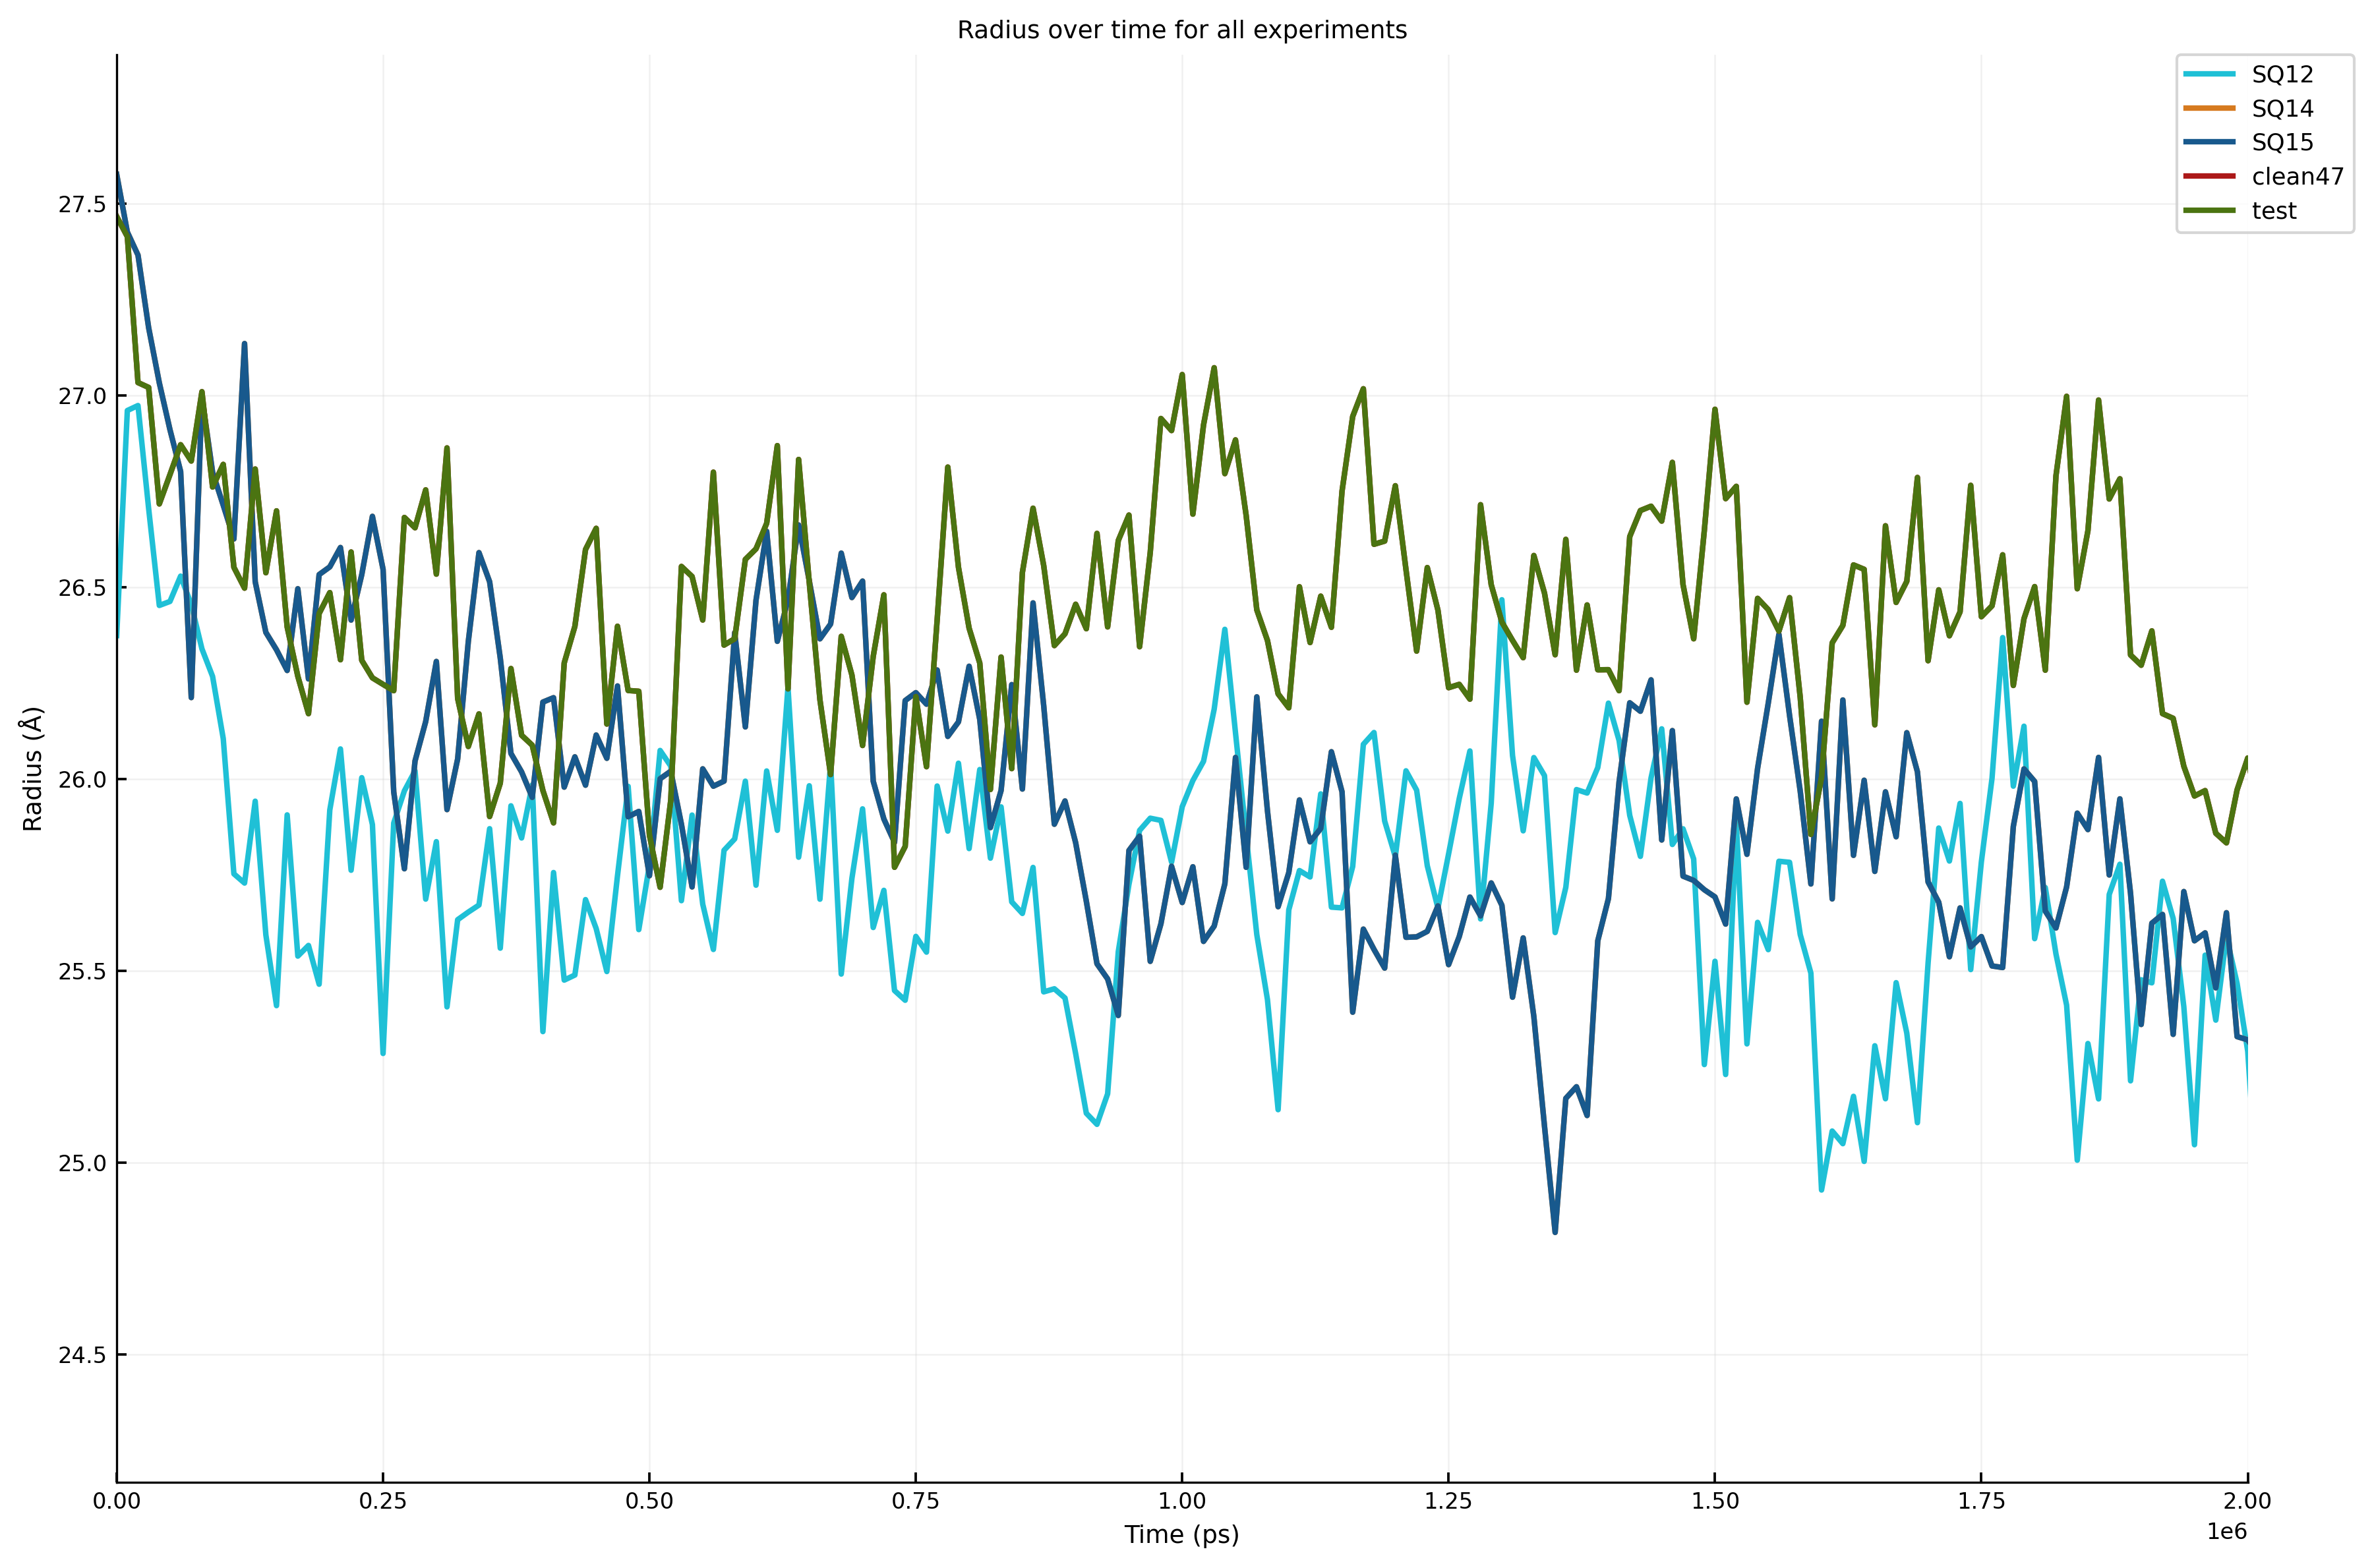

In [3]:

# Plot radius over time for each experiment
plt.figure(figsize=(12, 8))

for exp_name in sorted(experiment_names):
    try:
        # Load radius data
        radius_file = data_path / f"{exp_name}_radius.csv"
        if not radius_file.exists():
            print(f"No radius data for {exp_name}, skipping...")
            continue
            
        df = pd.read_csv(radius_file)
        
        # Assuming first column is time and second is radius
        time_col = df.columns[0]
        radius_col = df.columns[1]
        
        plt.plot(df[time_col], df[radius_col], label=exp_name)
    except Exception as e:
        print(f"Error processing {exp_name}: {e}")

plt.xlabel('Time (ps)')
plt.ylabel('Radius (Å)')
plt.title('Radius over time for all experiments')
plt.legend(loc='best', bbox_to_anchor=(1.05, 1), borderaxespad=0.)
plt.grid(True, alpha=0.3)
plt.xlim([0,2e6])
plt.tight_layout()
plt.show()

### Define which to exclude

'motor2m_frac-0' seems to be from other experiment and has some weird molecules

In [4]:
experiments_to_exclude = ['test', 'long', 'SQ14'] 

In [5]:
valid_experiments = sorted(list(experiment_names - set(experiments_to_exclude)))
print(f"Analyzing {len(valid_experiments)} experiments: {valid_experiments}")

# Define utility function to get experiment ratio (molecule A vs B)
def get_experiment_ratio(exp_name, data_path=Path('../data')):
    return 0
def get_experiment_squeeze(exp_name):
    if '12' in exp_name:
        return 12
    if '14' in exp_name:
        return 15
    return 9
# Get ratio for each experiment
experiment_ratios = {exp: get_experiment_ratio(exp) for exp in valid_experiments}
print("Experiment ratios (fraction of molecule B):")
for exp, ratio in experiment_ratios.items():
    if ratio is not None:
        print(f"  {exp}: {ratio}")

Analyzing 3 experiments: ['SQ12', 'SQ15', 'clean47']
Experiment ratios (fraction of molecule B):
  SQ12: 0
  SQ15: 0
  clean47: 0


## Data Management

In [6]:
def concat_global(data_path=Path('../data')):
    """
    Concatenate a global parameter across all valid experiments.
    
    Args:
        param_name: Name of the global parameter
        data_path: Path to data directory
        
    Returns:
        DataFrame with columns: time, parameter, experiment, ratio
    """
    all_data = []
    
    for exp_name in valid_experiments:
        # Handle special parameters

        # Load box_z data and convert to packing
        file_path = data_path / f"{exp_name}_box-z.csv"
        if not file_path.exists():
            continue
            
        df = pd.read_csv(file_path)
        df.columns = ['time', 'box-z']
        df['packing'] = NMOLS / (df['box-z'] / 10) # Box in Å to packing in mols/nm
        df = df[['time', 'packing']]  # Only keep time and packing
        file_path = data_path / f"{exp_name}_sasa.csv"
        if not file_path.exists():
            continue
        df2 = pd.read_csv(file_path)
        df2.columns = ['time', 'sasa']
        df['sasa'] = df2['sasa'] / NMOLS # sasa per motor
        file_path = data_path / f"{exp_name}_radius.csv"
        if not file_path.exists():
            continue
        df3 = pd.read_csv(file_path)
        df3.columns = ['time', 'radius']
        df['radius'] = df3['radius'] / 10 # Make to nm     
            


        # Add experiment name
        df['experiment'] = exp_name
        
        # Get ratio information
        df['ratioB'] = get_experiment_ratio(exp_name)
        df['squeeze'] = get_experiment_squeeze(exp_name)
            
        all_data.append(df)
    
    if not all_data:
        return pd.DataFrame()  # Return empty DataFrame if no data found
        
    return pd.concat(all_data, ignore_index=True)

def concat_all(data_path=Path('../data'), return_missing: bool = False):
    """
    Concatenate all parameters across all valid experiments.
    
    Creates a summary DataFrame with averages for the last 50% of time frames,
    separated by molecule type (A and B).
    
    Also detects experiments with partial data (some but not all parameters present)
    and prints a warning. If return_missing=True, also returns a DataFrame report.

    Args:
        data_path: Path to data directory
        return_missing: If True, return (result_df, missing_report_df)

    Returns:
        DataFrame with columns: experiment, ratioB, molecule, squeeze, <params...>, std-<local params...>
        If return_missing=True: (result_df, missing_report_df)
    """
    all_results = []
    missing_rows = []

    # Build expected parameter set (note: 'box-z' becomes 'packing' after transform)
    expected_params = set()
    for p in parameter_names:
        expected_params.add('packing' if p == 'box-z' else p)
    for exp_name in valid_experiments:
        ratio = get_experiment_ratio(exp_name)
        squeeze = get_experiment_squeeze(exp_name)

        result_A = {'experiment': exp_name, 'ratioB': ratio, 'molecule': 'A', 'squeeze': squeeze}
        result_B = {'experiment': exp_name, 'ratioB': ratio, 'molecule': 'B', 'squeeze': squeeze}

        found_params = set()  # track successfully computed param names for this experiment

        for param_name in parameter_names:
            is_global = False
            is_torsion = False

            file_path = data_path / f"{exp_name}_{param_name}.csv"
            if not file_path.exists():
                # Missing raw file for this parameter in this experiment
                continue

            df = pd.read_csv(file_path)
            is_global = 'resid' not in df.columns
            is_torsion = param_name.startswith('torsion')

            # ----- special transforms / normalization -----
            if param_name == 'box-z':
                # Convert to packing (motors / nm) from box-z in Å
                df.columns = ['time', 'packing']
                df['packing'] = NMOLS / (df['packing'] / 10.0)
                param_name = 'packing'
                is_global = True

            elif param_name == 'sasa':
                df.columns = ['time', 'sasa']
                df['sasa'] = df['sasa'] / NMOLS
                is_global = True

            elif param_name == 'radius':
                df.columns = ['time', 'radius']
                df['radius'] = df['radius'] / 10
                df['diameter'] = 2*df['radius']
                # If it were Å, we would convert by /10. Keep comment to avoid future confusion.
                is_global = True

            elif is_torsion and 'resid' in df.columns:
                # Mirror torsions for resid 2 and 4: ONLY angle/time columns, not 'resid'
                angle_cols = [c for c in df.columns if c != 'resid']
                mask = df['resid'].isin([2, 4])
                if mask.sum() < 2:
                    print(f"Warning: torsion mirror check failed or sparse for {exp_name}_{param_name}")
                df.loc[mask, angle_cols] = df.loc[mask, angle_cols] * -1

            # ----- last 50% of frames & aggregation -----
            if is_global:
                total_frames = len(df)
                if total_frames < 2:
                    # too short to split — skip but record partial
                    continue
                last_half_start = total_frames // 2
                df = df.iloc[last_half_start:]

                # standardize 2-col format: ['time', param_name]
                if len(df.columns) >= 2:
                    df.columns = ['time', param_name] + list(df.columns[2:])

                mean_value = df[param_name].mean()

                result_A[param_name] = mean_value
                result_B[param_name] = mean_value
                found_params.add(param_name)

            else:
                if 'resid' not in df.columns:
                    print(f"Error; resid not in {exp_name}_{param_name}")
                    continue

                # Rename columns to standardized format - first column is resid, rest are timesteps
                time_columns = list(range(len(df.columns) - 1))
                df.columns = ['resid'] + time_columns

                # Get last 50% of time columns
                time_cols = [col for col in df.columns if col != 'resid']
                if len(time_cols) < 2:
                    continue
                last_half_cols = time_cols[len(time_cols)//2:]

                # Map resids to molecule types (A: 1,2; B: 3,4)
                df['type'] = df['resid'].map({1: 'A', 2: 'A', 3: 'B', 4: 'B'})

                # A
                df_A = df[df['type'] == 'A']
                if not df_A.empty:
                    A_time_avg = df_A[last_half_cols].mean(axis=1)
                    result_A[param_name] = A_time_avg.mean()
                    result_A[f'std-{param_name}'] = A_time_avg.std()
                    found_params.add(param_name)

                # B
                df_B = df[df['type'] == 'B']
                if not df_B.empty:
                    B_time_avg = df_B[last_half_cols].mean(axis=1)
                    result_B[param_name] = B_time_avg.mean()
                    result_B[f'std-{param_name}'] = B_time_avg.std()
                    found_params.add(param_name)

        # Record results
        if len(result_A) > 3:
            all_results.append(result_A)
        if len(result_B) > 3:
            all_results.append(result_B)

        # ----- missing data detection for this experiment -----
        missing = sorted(expected_params - found_params)
        present = sorted(found_params)
        completeness = (len(found_params) / max(1, len(expected_params)))

        if missing and present:
            print(f"[WARNING] Partial data for {exp_name} (squeeze={squeeze}, ratioB={ratio}): "
                  f"missing {len(missing)}/{len(expected_params)} → {missing}")

        missing_rows.append({
            'experiment': exp_name,
            'squeeze': squeeze,
            'ratioB': ratio,
            'present_n': len(present),
            'expected_n': len(expected_params),
            'completeness': completeness,
            'present_params': present,
            'missing_params': missing,
        })

    # Final tables
    result_df = pd.DataFrame(all_results)
    missing_report_df = pd.DataFrame(missing_rows).sort_values(['squeeze', 'ratioB', 'experiment']).reset_index(drop=True)

    if return_missing:
        return result_df, missing_report_df
    return result_df

print("Testing concat_global with 'radius':")
global_df = concat_global()
print(global_df.head())
print("\nTesting concat_all:")
all_df, missing = concat_all(return_missing=True)
all_df = all_df[all_df['molecule'] == 'A']
print(all_df.head())


Testing concat_global with 'radius':
      time    packing      sasa    radius experiment  ratioB  squeeze
0      0.0  17.355507  3.012250  2.637441       SQ12       0       12
1  10000.0  18.138869  2.854945  2.696106       SQ12       0       12
2  20000.0  18.428416  2.935840  2.697408       SQ12       0       12
3  30000.0  18.225189  2.911695  2.670529       SQ12       0       12
4  40000.0  17.638219  2.928805  2.645286       SQ12       0       12

Testing concat_all:
  experiment  ratioB molecule  squeeze       g-r      sasa    radius  \
0       SQ12       0        A       12  1.043137  2.959761  2.580363   
2       SQ15       0        A        9  1.040081  2.967805  2.563099   
4    clean47       0        A        9  1.007119  2.966185  2.623101   

     packing        RG    std-RG  
0  17.101930  8.390453  0.045819  
2  16.867373  8.387173  0.045056  
4  16.835492  8.388110  0.023349  


## Analysis

In [7]:
NMOLS = 200
Z_CI = 1.96

def summarize_parameters(all_df):
    """
    Compute mean and 95% CI per (squeeze, ratioB) for global parameters and
    per (squeeze, ratioB, molecule) for local parameters (A/B),
    using replicate-level summaries in all_df.
    """
    global_params = ['radius', 'sasa', 'packing', 'diameter']
    local_params = [c for c in all_df.columns
                    if not c.startswith('std-')
                    and c not in global_params
                    and c not in ['experiment','ratioB','molecule','squeeze']]

        # --- compute derived density per experiment ---
    all_df = all_df.copy()
    all_df['density'] = all_df['packing']/ (np.pi * all_df['radius']**2)
    all_df['diameter'] = all_df['radius']*2
    global_params.append('density')

    results = []

    # ---------- GLOBAL PARAMETERS ----------
    for p in global_params:
        if p not in all_df.columns:
            continue
        df = all_df[['ratioB', p]].dropna()
        if df.empty:
            continue
        grouped = df.groupby([ 'ratioB'])[p]
        res = grouped.agg(['mean', 'std', 'count']).reset_index()
        res['count'] = res['count'] 
        res['sem'] = res['std'] / np.sqrt(res['count'])
        res['CI'] = Z_CI * res['sem']
        res['parameter'] = p
        results.append(res[['parameter', 'ratioB', 'mean', 'std','count','CI']])

    # ---------- LOCAL PARAMETERS (per squeeze, ratioB, molecule) ----------
    for p in local_params:
        std_col = f'std-{p}'
        if std_col not in all_df.columns:
            continue

        df = all_df[['ratioB','molecule',p,std_col]].dropna()
        if df.empty:
            continue

        grouped = df.groupby(['ratioB','molecule'])
        tmp = []

        for (rb, mol), g in grouped:
            # determine group molecule count from ratioB (assumed percent)
            nB = int(round((rb/100.0) * NMOLS))
            nA = NMOLS - nB
            n_mols = nB if mol == 'B' else nA

            # if a group has zero molecules (e.g., ratioB=0 and mol=='B'), skip safely
            if n_mols <= 1:
                print(f"[warn] n_mols <= 1 for (ratioB={rb}, molecule={mol}); skipping {p}")
                continue

            k = len(g)  # number of replicate experiments in this cell
            print(k)

            mean = g[p].mean()

            # pooled within-fibre variance across replicates (use correct n per replicate)
            # since n_mols is constant within a (sq, rb, mol) cell, this simplifies,
            # but we keep the general pooled formula for safety:
            vd_pooled_num = ((n_mols - 1) * (g[std_col] ** 2)).sum()
            vd_pooled_den = k * (n_mols - 1)
            vd_pooled = vd_pooled_num / vd_pooled_den if vd_pooled_den > 0 else np.nan

            # variance between replicate means
            vd_between = g[p].var(ddof=1) if k > 1 else 0.0

            # component from within-molecule variance for the mean of a single replicate
            within_component = vd_pooled / n_mols if np.isfinite(vd_pooled) else 0.0

            # conservative SEM for the averaged mean over k replicates:
            # take the dominating component, then divide by k
            sem = np.sqrt(max(within_component, vd_between) / k)
            ci  = Z_CI * sem

            tmp.append(dict(parameter=p, ratioB=rb, molecule=mol,
                            mean=mean, CI=ci, count=k, n_mols=n_mols))

        if tmp:
            results.append(pd.DataFrame(tmp))

    summary = pd.concat(results, ignore_index=True) if results else pd.DataFrame()
    return summary


# usage
summary_df = summarize_parameters(all_df)
print(summary_df)

3
  parameter  ratioB       mean       std  count        CI molecule  n_mols
0    radius       0   2.588854  0.030889      3  0.034955      NaN     NaN
1      sasa       0   2.964584  0.004254      3  0.004814      NaN     NaN
2   packing       0  16.934932  0.145501      3  0.164649      NaN     NaN
3  diameter       0   5.177709  0.061779      3  0.069909      NaN     NaN
4   density       0   0.804565  0.022283      3  0.025215      NaN     NaN
5        RG       0   8.388579       NaN      3  0.003159        A   200.0


## G(r)

In [11]:
# analyze_gr.py
from __future__ import annotations
from dataclasses import dataclass
from typing import Dict, Iterable, List, Tuple, Optional

from scipy.signal import savgol_filter  # for Savitzky–Golay smoothing

@dataclass
class GRAnalysisResult:
    r: np.ndarray
    weighted_gr_df: pd.DataFrame
    smoothed_df: Optional[pd.DataFrame]
    peaks: Dict[str, Dict[str, float]]
    weighted_gr: Dict[str, np.ndarray]
    weighted_std: Dict[str, np.ndarray]
    used_experiments: List[str]
    messages: List[str]


def analyze_weighted_gr_styled(
    experiment_ratios: Dict[str, float],
    data_dir: str = "../data",
    NMOLS: int = 200,
    r_range: Optional[Tuple[float, float]] = None,
    use_ordered_pairs: bool = True,   # True keeps your N_i*(N_i-1) choice
    savgol_window: Optional[int] = None,
    savgol_poly: int = 3,
    interpolate_if_mismatch: bool = True,
) -> GRAnalysisResult:
    """
    Weighted-average g(r) across experiments with optional Savitzky–Golay smoothing.
    Returns data + diagnostics (no plotting). To plot, call plot_weighted_gr_with_styler(...).
    """

    msgs: List[str] = []

    # ---- read all CSVs
    experiment_data: Dict[str, pd.DataFrame] = {}
    molecule_counts: Dict[str, Dict[int, int]] = {}
    r_col = "r (Å)" #should be r(Å)
    for expt, ratioB_pct in experiment_ratios.items():
        if ratioB_pct == None:
            continue
        # compute counts: A vs B split, and R vs S split 50:50
        n_A = int(round((100.0 - ratioB_pct) / 100.0 * NMOLS))
        n_B = NMOLS - n_A
        # split each evenly over R/S
        N_1 = int(round(n_A / 2))  # A-R
        N_2 = n_A - N_1            # A-S
        N_3 = int(round(n_B / 2))  # B-R
        N_4 = n_B - N_3            # B-S

        # sanity
        if (N_1 + N_2 + N_3 + N_4) != NMOLS:
            msgs.append(f"[warn] {expt}: counts round to {N_1+N_2+N_3+N_4} ≠ {NMOLS}. Adjusted by last bin.")
        molecule_counts[expt] = {1: N_1, 2: N_2, 3: N_3, 4: N_4}

        fp = os.path.join(data_dir, f"{expt}_g-r.csv")
        if not os.path.exists(fp):
            msgs.append(f"[warn] file not found: {fp}")
            continue

        df = pd.read_csv(fp)
        if r_col not in df.columns:
            msgs.append(f"[warn] {expt}: missing 'r (Å)' column")
            continue

        experiment_data[expt] = df

    used = list(experiment_data.keys())
    if not used:
        raise ValueError("No valid data files found.")

    # ---- choose base r-grid and check consistency
    base_r = experiment_data[used[0]][r_col].to_numpy()
    grids_ok = True
    for expt, df in experiment_data.items():
        r_here = df[r_col].to_numpy()
        if r_here.shape != base_r.shape or not np.allclose(r_here, base_r, rtol=0, atol=1e-8):
            grids_ok = False
            msgs.append(f"[warn] {expt}: r-grid differs from first dataset")
    if not grids_ok:
        if interpolate_if_mismatch:
            msgs.append("[info] interpolating all g(r) columns onto the first dataset’s r-grid")
            for expt, df in experiment_data.items():
                if df[r_col].to_numpy().shape != base_r.shape or not np.allclose(df[r_col], base_r):
                    # interpolate every g(r) column
                    r_src = df[r_col].to_numpy()
                    for col in df.columns:
                        if col.startswith("g(r)"):
                            df[col] = np.interp(base_r, r_src, df[col].to_numpy())
                    df[r_col] = base_r
        else:
            msgs.append("[error] r-grids mismatch and interpolate_if_mismatch=False")

    r = base_r.copy()

    # ---- r-range mask
    if r_range is not None:
        rmin, rmax = r_range
        mask = (r >= rmin) & (r <= rmax)
        r = r[mask]
    else:
        mask = slice(None)

    # ---- define interaction mapping (skip AR–BR and AR–BS later when plotting)
    interaction_mapping = {
        "AR-AR":   ["g(r) 1-1", "g(r) 2-2"],
        "AR-AS": ["g(r) 1-2"],
    }

    weighted_gr: Dict[str, np.ndarray] = {}
    weighted_std: Dict[str, np.ndarray] = {}
    weights_sum: Dict[str, float] = {}
    peak_positions: Dict[str, List[Tuple[float, float]]] = {k: [] for k in interaction_mapping}

    for inter, columns in interaction_mapping.items():
        weighted_gr[inter] = np.zeros_like(r)
        weights_sum[inter] = 0.0
        all_values: List[np.ndarray] = []
        all_weights: List[float] = []

        for expt, df in experiment_data.items():
            vals_here: List[np.ndarray] = []
            weights_here: List[float] = []

            for col in columns:
                if col not in df.columns:
                    msgs.append(f"[warn] {expt}: column missing: {col}")
                    continue

                # parse pair ids
                i, j = (int(x) for x in col.split()[-1].split("-"))
                Ni = molecule_counts[expt][i]
                Nj = molecule_counts[expt][j]

                if i == j:
                    weight = Ni * (Ni - 1) if use_ordered_pairs else Ni * (Ni - 1) / 2.0
                else:
                    weight = Ni * Nj

                vals_here.append(df[col].to_numpy()[mask])
                weights_here.append(float(weight))

            if vals_here:
                total_w = float(np.sum(weights_here))
                # within-experiment weighted mean across symmetric columns
                exp_avg = np.zeros_like(r, dtype=float)
                for v, w in zip(vals_here, weights_here):
                    exp_avg += v * (w / total_w)

                all_values.append(exp_avg)
                all_weights.append(total_w)

                # peak for this experiment
                pk_idx = int(np.nanargmax(exp_avg))
                peak_positions[inter].append((float(r[pk_idx]), total_w))

                weighted_gr[inter] += exp_avg * total_w
                weights_sum[inter] += total_w

        if weights_sum[inter] > 0:
            weighted_gr[inter] /= weights_sum[inter]

            # weighted variance (sample); guard small-n
            all_values = np.asarray(all_values)
            all_weights = np.asarray(all_weights, dtype=float)
            if all_values.shape[0] > 1:
                diff2 = np.zeros_like(r, dtype=float)
                for v, w in zip(all_values, all_weights):
                    diff2 += w * (v - weighted_gr[inter]) ** 2
                correction = 1.0 - np.sum(all_weights**2) / (np.sum(all_weights) ** 2)
                if correction <= 0:
                    weighted_std[inter] = np.full_like(r, np.nan, dtype=float)
                else:
                    var = diff2 / (np.sum(all_weights) * correction)
                    weighted_std[inter] = np.sqrt(var)
            else:
                weighted_std[inter] = np.full_like(r, np.nan, dtype=float)
        else:
            weighted_std[inter] = np.full_like(r, np.nan, dtype=float)

    # ---- construct DataFrames
    result_df = pd.DataFrame({"r (Å)": r})
    n_expt = len(used)
    for inter in interaction_mapping:
        result_df[f"g(r) {inter}"] = weighted_gr[inter]
        ci = 1.96 * weighted_std[inter] / np.sqrt(max(n_expt, 1))
        result_df[f"CI95 {inter}"] = ci

    # ---- peaks summary
    peaks: Dict[str, Dict[str, float]] = {}
    for inter in interaction_mapping:
        grv = weighted_gr[inter]
        pk_idx = int(np.nanargmax(grv))
        peak_r = float(r[pk_idx])
        peak_gr = float(grv[pk_idx])
        peak_gr_ci = float(1.96 * (weighted_std[inter][pk_idx] if np.isfinite(weighted_std[inter][pk_idx]) else np.nan) / np.sqrt(max(n_expt, 1)))

        if peak_positions[inter]:
            pos, wts = zip(*peak_positions[inter])
            pos = np.asarray(pos, dtype=float)
            wts = np.asarray(wts, dtype=float)
            if len(pos) > 1:
                w_mean = float(np.sum(pos * wts) / np.sum(wts))
                diff2 = float(np.sum(wts * (pos - w_mean) ** 2))
                corr = 1.0 - float(np.sum(wts**2) / (np.sum(wts) ** 2))
                if corr > 0:
                    std_r = np.sqrt(diff2 / (np.sum(wts) * corr))
                    peak_r_ci = float(1.96 * std_r / np.sqrt(len(pos)))
                else:
                    peak_r_ci = np.nan
            else:
                w_mean = pos[0]
                peak_r_ci = np.nan
        else:
            w_mean = peak_r
            peak_r_ci = np.nan

        peaks[inter] = {"r": w_mean, "r_CI95": peak_r_ci, "g(r)": peak_gr, "g(r)_CI95": peak_gr_ci}

    # ---- optional Savitzky–Golay smoothing (for export convenience)
    smoothed_df = None
    if savgol_window and savgol_window > 2 and savgol_window % 2 == 1:
        smoothed_df = pd.DataFrame({"r (Å)": r})
        for inter in interaction_mapping:
            y = weighted_gr[inter]
            ci = result_df[f"CI95 {inter}"].to_numpy()
            y_sm = savgol_filter(y, savgol_window, savgol_poly, mode="interp")
            ci_sm = savgol_filter(ci, savgol_window, savgol_poly, mode="interp")
            smoothed_df[f"g(r) {inter}"] = y_sm
            smoothed_df[f"CI95 {inter}"] = ci_sm
    elif savgol_window is not None:
        msgs.append("[warn] savgol_window must be odd and >= 3; smoothing skipped")

    return GRAnalysisResult(
        r=r,
        weighted_gr_df=result_df,
        smoothed_df=smoothed_df,
        peaks=peaks,
        weighted_gr=weighted_gr,
        weighted_std=weighted_std,
        used_experiments=used,
        messages=msgs,
    )


def plot_weighted_gr_with_styler(
    res: GRAnalysisResult,
    sty: Optional[MDStyler] = None,
    use_savgol: bool = True,
    exclude_pairs: Iterable[str] = ("AR-BR", "AR-BS"),  # per your instruction
    square: bool = False,
    title: Optional[str] = None,
) -> Tuple[plt.Figure, plt.Axes]:
    """
    Plot weighted g(r) + 95% CI using your MDStyler.
    AA solid vs CG dashed is not semantically meaningful here, so we use solid lines
    with shaded CI; line dashes can be used to differentiate families if you wish.
    """
    sty = sty or MDStyler().apply()
    fig, ax = (sty.fig_square() if square else sty.fig_horizontal())

    # choose which table to plot
    df = res.smoothed_df if (use_savgol and res.smoothed_df is not None) else res.weighted_gr_df
    r = res.r

    # which interactions to draw (respect exclusion)
    cols = [c for c in df.columns if c.startswith("g(r) ")]
    inter_names = [c.replace("g(r) ", "") for c in cols]
    draw = [(n, c) for n, c in zip(inter_names, cols) if n not in set(exclude_pairs)]

    pal = sty.get_palette(len(draw))
    for color, (name, col) in zip(pal, draw):
        y = df[col].to_numpy()
        # CI column key
        ci_key = col.replace("g(r)", "CI95")
        ci = df[ci_key].to_numpy() if ci_key in df.columns else np.full_like(y, np.nan)

        ax.plot(r, y, color=color, label=name)
        # matte translucent band
        ax.fill_between(r, y - ci, y + ci, color=color, alpha=0.18)

    ax.set_xlabel("r (Å)")
    ax.set_ylabel("g(r)")
    if title:
        ax.set_title(title)

    ax.legend(frameon=False, ncol=2)
    return fig, ax

print(experiment_ratios)
res = analyze_weighted_gr_styled(
    {"clean47": 0, "SQ15": 0, "SQ12": 0},
    data_dir="../data",
    NMOLS=200,
    r_range=(0.0, 20.0),
    savgol_window=15,   # odd, >=3
    savgol_poly=3,
)
for m in res.messages:
    print(m)

{'SQ12': 0, 'SQ15': 0, 'clean47': 0}


In [ ]:

fig, ax = plot_weighted_gr_with_styler(
    res,
    sty=sty,
    use_savgol=True,
    square=False,
    title=None,
)
plt.ylim([0,1.5])
plt.title("CG", fontsize=11, fontweight="bold", y=1.02)
plt.show()

## Diffusion

In [ ]:
msd_path = "../data/diffusion_results_msd_data.txt"
drift_path = "../data/diffusion_results_drift.txt"

# ---------------------------------------------------------------------
# Load data
# ---------------------------------------------------------------------
data = np.loadtxt(msd_path)
time_ps   = data[:, 0]   # ps
msd_z_A2  = data[:, 3]   # Z column (physically your Y direction, per convention)


# ---------------------------------------------------------------------
# Unit conversion: ps -> μs, Å² -> nm²
# ---------------------------------------------------------------------
time_us      = time_ps / 1e6
msd_z_nm2    = msd_z_A2 * 0.01  # Å² -> nm²
N            = len(time_us)

# ---------------------------------------------------------------------
# Main fit window: fixed 0.2–0.8 (in fraction of trajectory)
# ---------------------------------------------------------------------
main_start_frac = 0.2
main_end_frac   = 0.8

main_start_idx = int(main_start_frac * N)
main_end_idx   = int(main_end_frac * N)

slope_main, intercept_main, r_value_main, p_value_main, std_err_main = stats.linregress(
    time_us[main_start_idx:main_end_idx],
    msd_z_nm2[main_start_idx:main_end_idx]
)

D_main = slope_main / 2.0  # 1D diffusion
r2_main = r_value_main**2

# Fitted line for the main window
fit_line_main = slope_main * time_us + (
    msd_z_nm2[main_start_idx] - slope_main * time_us[main_start_idx]
)

# ---------------------------------------------------------------------
# Window sampling around the main window to estimate sensitivity
# ---------------------------------------------------------------------
# Sample a grid of start/end fractions around [0.2, 0.8]
start_fracs = np.linspace(0.1, 0.5, 5)  # 0.15–0.25
end_fracs   = np.linspace(0.75, 1, 5)  # 0.75–0.85

D_samples = []
fit_lines = []  # for plotting faint sampled fits

min_points = 20  # require at least this many points per fit

for s_frac in start_fracs:
    for e_frac in end_fracs:
        if e_frac <= s_frac:
            continue

        i0 = int(s_frac * N)
        i1 = int(e_frac * N)

        if i1 - i0 < min_points:
            continue

        # Linear fit for this window
        slope, intercept, r_val, p_val, std_err = stats.linregress(
            time_us[i0:i1],
            msd_z_nm2[i0:i1]
        )
        D = slope / 2.0
        D_samples.append(D)

        # store fit line segment for plotting
        local_fit = slope * time_us + (msd_z_nm2[i0] - slope * time_us[i0])
        fit_lines.append((i0, i1, local_fit))

D_samples = np.array(D_samples)

if len(D_samples) == 0:
    print("⚠️ No valid sampled windows found; only main fit will be shown.")
    D_mean = D_main
    D_std  = 0.0
else:
    D_mean = np.mean(D_samples)
    D_std  = np.std(D_samples)

print(f"Main window  : [{main_start_frac:.2f}, {main_end_frac:.2f}]")
print(f"D_main       = {D_main:.3e} nm²/μs")
print(f"D_mean(win)  = {D_mean:.3e} nm²/μs")
print(f"σ_window(D)  = {D_std:.3e} nm²/μs")
print(f"R²(main fit) = {r2_main:.3f}")

# ---------------------------------------------------------------------
# Plot using MDStyler
# ---------------------------------------------------------------------
sty = MDStyler().apply()
# colors: data, main fit, sampled fits
c_data, c_main_fit, c_sample = sty.get_palette(3)

fig, ax = sty.fig_horizontal()

# 2) Plot MSD data
ax.plot(
    time_us,
    msd_z_nm2,
    color=c_data,
    **sty.as_aa(label="MSD$_z$")
)

# 3) Plot all sampled fit lines faintly
for i0, i1, local_fit in fit_lines:
    ax.plot(
        time_us[i0:i1],
        local_fit[i0:i1],
        color=c_sample,
        linewidth=1.0,
        alpha=0.15,
        linestyle=sty.ls_cg  # faint dashed
    )

# 4) Plot the main fit line (bold)
ax.plot(
    time_us[main_start_idx:main_end_idx],
    fit_line_main[main_start_idx:main_end_idx],
    color=c_main_fit,
    **sty.as_cg(label="Linear fit")
)

# Labels, title
ax.set_xlabel(r"Time ($\mu$s)")
ax.set_ylabel(r"MSD$_z$ (nm$^2$)")

ax.set_title(
    r"D$_z$ = "
    + f"{D_main:.2e}"
    + r" nm$^2$/$\mu$s"
    + " "
    + r"$\pm$"
    + f" {D_std:.1e}"
)

ax.legend(frameon=False)

plt.show()